# **AAL Australia: 4Q Sales Report**


## **1. Data Wrangling**


### **1.1 Data Inspection**

_It's the process of getting familiar with the data in order to identify quality and structure issues._


In [ ]:
import pandas as pd

df = pd.read_csv("./Data/AAL_Q4-2020_Sales.csv")

print("First 5 rows of the DataFrame:")
print(df.head(5))

print(f"\nLast 5 rows of the DataFrame:")
print(df.tail(5))

print("\nDataFrame Summary")
print(df.info())

has_null = df.isnull().values.any()
print("\nDoes the DataFrame have any null value?:", has_null)

number_of_duplicates = df.duplicated().sum()
print(f"\nNumber of duplicates: {number_of_duplicates}")

print("\nList of numerical columns:")
numerical_columns = df.select_dtypes(include=["number"]).columns
print(numerical_columns)

print("\nList of categorical columns:")
categorical_columns = df.select_dtypes(exclude=["number"]).columns
print(categorical_columns)

### **1.2 Data Cleaning**

_It's the process of handling missing data, removing duplicates, converting data types, trimming whitespace, correcting inconsistencies, standardizing formats, dealing with outliers, and validating accuracy._


In [ ]:
# Handling duplicates:
if number_of_duplicates > 0:
    df = df.drop_duplicates(keep="first")

# Handling missing data for numerical columns:
for column in numerical_columns:
    if df[column].isnull().any():
        column_median = df[column].median()
        df[column] = df[column].fillna(column_median)

# Handling missing data for categorical columns:
for column in categorical_columns:
    if df[column].isnull().any():
        df[column] = df[column].fillna("Unknown")


# Identify and correct misspelled words and unnecessary whitespace:
for column in categorical_columns:
    if column != "Date":
        df[column] = df[column].str.strip()
        unique_values = df[column].unique()
        print(f"{column} unique values: {unique_values}")

# Handling Outliers:
SALES_COLUMN = "Sales"

q1 = df[SALES_COLUMN].quantile(0.25)
q3 = df[SALES_COLUMN].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Tagging all the 'sales outliers' with True or False
condition = (df[SALES_COLUMN] >= lower_bound) & (df[SALES_COLUMN] <= upper_bound)
df["Sales_Outlier"] = ~condition

### **1.3 Data Transformation**

_It involves converting data from its original form into a format that is more suitable for analysis._


In [ ]:
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler

# Transforming Date column to YYYY-MM-DD:
DATE_COLUMN = "Date"
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN], format="%d-%b-%Y")


# Encoding categorical data into numerical:
def encode(df: DataFrame, original_column: str, new_column: str):
    df[new_column], _unique = pd.factorize(df[original_column])


ORIGINAL_COLUMNS = ["Time", "State", "Group"]
NEW_COLUMNS = ["Numerical_Time", "Numerical_State", "Numerical_Group"]

for original_column, new_column in zip(ORIGINAL_COLUMNS, NEW_COLUMNS):
    encode(df, original_column, new_column)


# Binning Sales column to create Sales_Range:
SALES_RANGE = "Sales_Range"

min = df[SALES_COLUMN].min()
q2 = df[SALES_COLUMN].quantile(0.5)
max = df[SALES_COLUMN].max()

bin_edges = [min, q1, q2, q3, max]
bin_labels = ["0-25%", "25%-50%", "50%-75%", "75%-100%"]

df[SALES_RANGE] = pd.cut(
    df[SALES_COLUMN], bins=bin_edges, labels=bin_labels, include_lowest=True
)

# Normalization
cleaned_df = df.copy(deep=True)
normalized_df = cleaned_df.copy(deep=True)
new_numerical_columns = normalized_df.select_dtypes(include=["number"]).columns

SCALER = MinMaxScaler()

normalized_df[new_numerical_columns] = SCALER.fit_transform(
    normalized_df[new_numerical_columns]
)

## **2. Data Saving**

_It involves creating a new DataFrame with the wrangled data and save it into a new csv file._


In [ ]:
cleaned_df.to_csv("./Data/AAL_Q4-2020_Sales_Cleaned.csv", index=False)
normalized_df.to_csv("./Data/AAL_Q4-2020_Sales_Cleaned_and_Normalized.csv", index=False)

## **3. Data Analysis**


### **3.1 Descriptive Statistical Analysis**


In [ ]:
cleaned_stats = cleaned_df["Sales"].describe().round()
print(cleaned_stats)

"""
The dataset of 7,560 sales records shows a broad range of sales amounts from $5,000 to $162,500, highlighting diverse
transaction sizes.

With an average sale of $45,014 but a high standard deviation of $32,254, the data reveals a wide spread of sales figures,
indicating a mix of low, medium, and high transactions.

The sales distribution is right-skewed, as shown by 25% of sales being $20,000 or below, the median at $35,000, and 75% of sales
not exceeding $65,000, though some transactions reach up to $162,500, suggesting outlier or high-value sales.

The insights point towards focusing strategies on enhancing the value of transactions in the lower quartiles, targeting
medium-value transactions for growth, and learning from high-value sales to boost overall performance.
"""

#### **3.1.1 Box Plot Chart**


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
boxprops = dict(facecolor="lightblue")
medianprops = dict(color="green")
meanlineprops = dict(color="red", linestyle="--")
boxplot_elements = plt.boxplot(
    cleaned_df["Sales"],
    vert=False,
    patch_artist=True,
    notch=True,
    showmeans=True,
    boxprops=boxprops,
    meanline=True,
    meanprops=meanlineprops,
    medianprops=medianprops,
)

plt.title("Sales Box Plot")
plt.xlabel("Sales Amount")
plt.yticks([1], ["Sales"])
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

medians = boxplot_elements["medians"][0].get_xydata()[1, 0]
means = cleaned_df["Sales"].mean()

median_pos = medians + ((plt.xlim()[1] - plt.xlim()[0]) * 0.01)
mean_pos = means + ((plt.xlim()[1] - plt.xlim()[0]) * 0.01)

plt.text(
    median_pos,
    1.02,
    f"Median: {medians:.2f}",
    verticalalignment="center",
    color="green",
)
plt.text(mean_pos, 0.98, f"Mean: {means:.2f}", verticalalignment="center", color="red")


plt.show()

### **3.2 Ranking Analysis**


In [ ]:
ranking_df = cleaned_df.copy(deep=True)

# Units:
sales_by_unit = ranking_df.groupby("Unit")["Sales"].sum().reset_index()
sorted_sales_by_unit = sales_by_unit.sort_values("Sales", ascending=False)

top_3_units = sorted_sales_by_unit.head(3)
bottom_3_units = sorted_sales_by_unit.tail(3)

print("\nTop 3 STORES (Units) with the highest total sales:")
print(top_3_units)

print("\nBottom 3 STORES (Units) with the lowest total Sales:")
print(bottom_3_units.sort_values("Sales", ascending=True))

# State:
sales_by_state = ranking_df.groupby("State")["Sales"].sum().reset_index()
sorted_sales_by_state = sales_by_state.sort_values("Sales", ascending=False)

top_3_states = sorted_sales_by_state.head(3)
bottom_3_states = sorted_sales_by_state.tail(3)

print("\nTop 3 STATES with the highest total sales:")
print(top_3_states)

print("\nBottom 3 STATES with the lowest total Sales:")
print(bottom_3_states.sort_values("Sales", ascending=True))

#### **3.2.1 Ranking Analysis Visualizations**


In [ ]:
import matplotlib.ticker as ticker

# [Chart] Top 3 STORES (Units) with the highest total sales:
plt.figure(figsize=(10, 6))
bars = plt.bar(top_3_units["Unit"], top_3_units["Sales"], color="green")

plt.title("Top 3 Units with the Highest Total Sales")
plt.xlabel("Store Unit")
plt.ylabel("Total Sales")

plt.ylim([1_000_000, 15_000_000])
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{int(yval):,}",
        ha="center",
        va="bottom",
    )

plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# [Chart] Top 3 STATES with the highest total sales:
plt.figure(figsize=(10, 6))
bars = plt.bar(top_3_states["State"], top_3_states["Sales"], color="Green")

plt.title("Top 3 States with the Highest Total Sales")
plt.xlabel("State")
plt.ylabel("Total Sales")

plt.ylim([50_000_000, 110_000_000])
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{int(yval):,}",
        ha="center",
        va="bottom",
    )

plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

### **3.3 Pivot Tables**


In [ ]:
pivot_df = cleaned_df.copy(deep=True)

pivot_df["Year"] = pivot_df["Date"].dt.year
pivot_df["Month"] = pivot_df["Date"].dt.month

pivot_table_1 = pd.pivot_table(
    pivot_df,
    values="Sales",
    index=["State", "Group"],
    columns=["Month"],
    aggfunc="sum",
    margins=True,
    margins_name="Total",
)

print("\n1st Pivot table: Total sales by State, Group, and Month")
print(pivot_table_1)

pivot_table_2 = pd.pivot_table(
    pivot_df,
    values="Sales",
    index=["State", "Group"],
    columns=["Month"],
    aggfunc="mean",
    margins=True,
    margins_name="Average",
).round(2)

print("\n 2nd Pivot table: Average sales by State, Group, and Month")
print(pivot_table_2)

#### **3.3.1 Pivot Tables Visualizations**


/var/folders/gz/7k9fk3hs61dfr5v91glrzn4m0000gn/T/ipykernel_62386/760685183.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pivot_table_1.drop(columns="Total").drop("Total"),


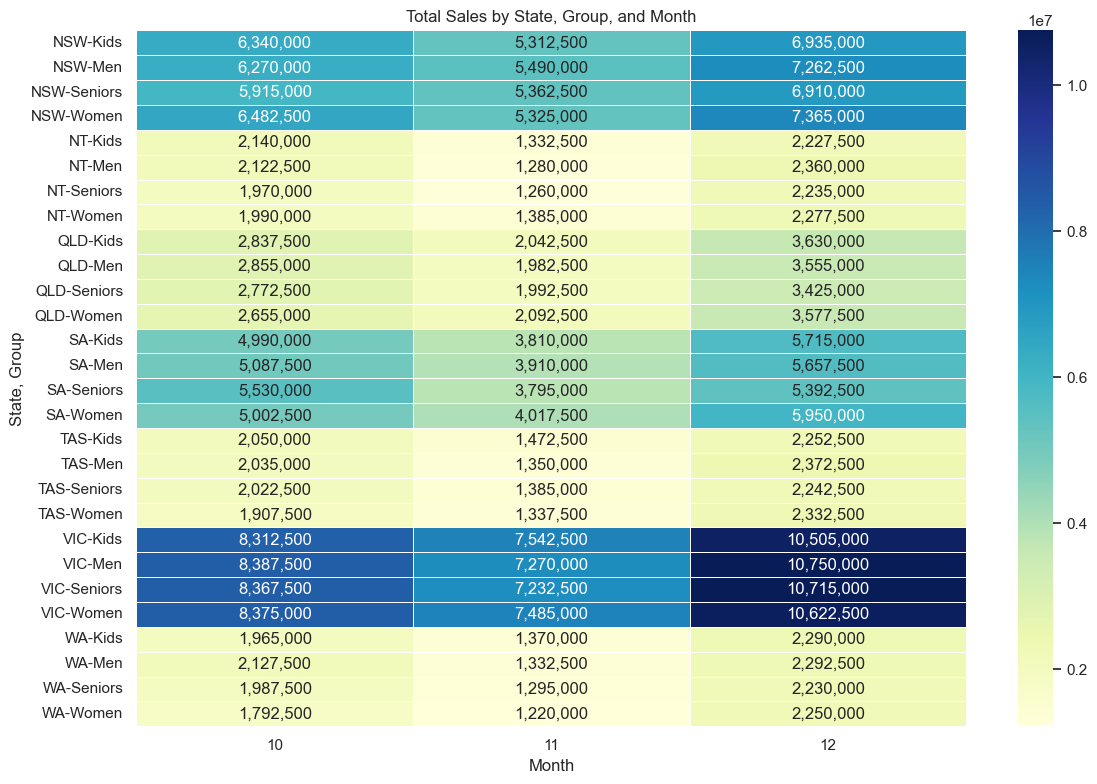

/var/folders/gz/7k9fk3hs61dfr5v91glrzn4m0000gn/T/ipykernel_62386/760685183.py:23: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pivot_table_2.drop(columns="Average").drop("Average"),


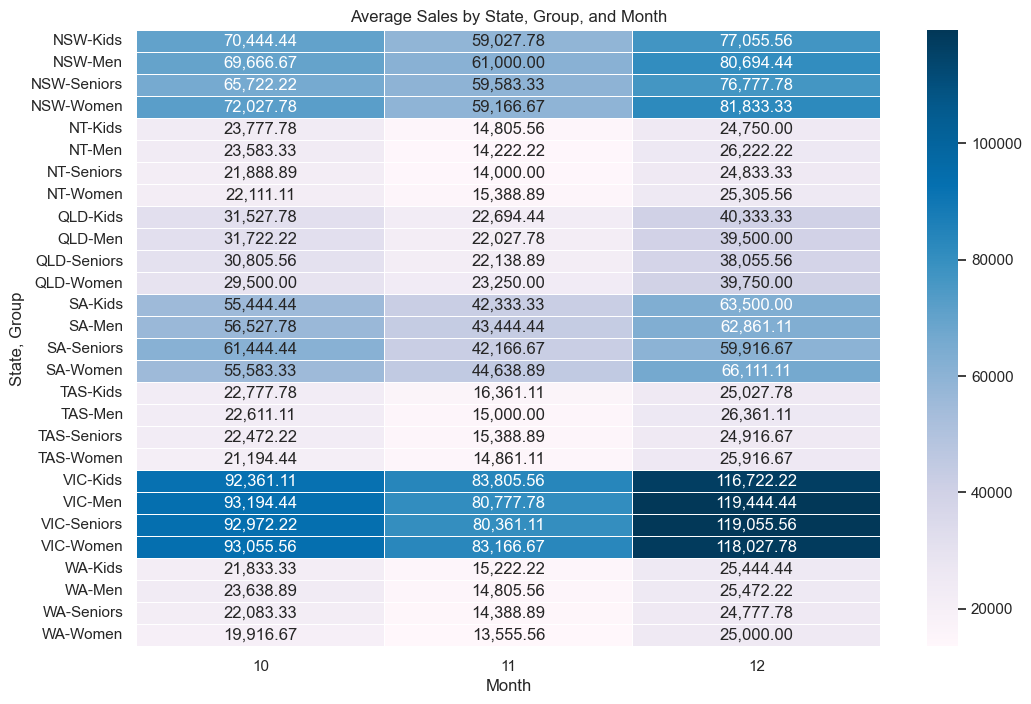

In [18]:
import seaborn as sns

sns.set_theme(style="whitegrid")

# [Chart] Total Sales Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table_1.drop(columns="Total").drop("Total"),
    annot=True,
    fmt=",",
    cmap="YlGnBu",
    linewidths=0.5,
)
plt.title("Total Sales by State, Group, and Month")
plt.ylabel("State, Group")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

# [Chart] Average Sales Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table_2.drop(columns="Average").drop("Average"),
    annot=True,
    fmt=",.2f",
    cmap="PuBu",
    linewidths=0.5,
)
plt.title("Average Sales by State, Group, and Month")
plt.ylabel("State, Group")
plt.xlabel("Month")
plt.show()